In [30]:
#install packages
# !pip install numpy
# !pip install tensorflow
# !pip install sklearn
# !pip install matplotlib.pyplot
# !pip install biopython

In [31]:
!pip install biopython

In [32]:
#load packages
import numpy as np
import tensorflow as tf
from Bio import SeqIO
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model #library to save model later
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Embedding,Reshape
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, matthews_corrcoef, roc_curve, accuracy_score, auc
from sklearn.utils import class_weight

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Pre-processing
Here, we are going to clean the training dataset and testing dataset. We will filter the sequences by removing the sequences in training set and testing dataset with 'X' occurences.

The new training dataset and testing dataset will be saved as `Train_valid.fasta` and `Test_valid.fasta` respectively. We will be using the new training and testing datasets for the remaining of our work for CNN.

In [34]:
# Define a function to filter sequences without 'X' and write to new file
def filter(input_file, output_file):
    with open(output_file, "w") as output_handle:
        # Read sequences from input file
        for record in SeqIO.parse(input_file, "fasta"):
            # Check if 'X' is present in the sequence
            if 'X' not in record.seq:
                # Write valid sequence to output file
                SeqIO.write(record, output_handle, "fasta")

In [35]:
# File paths
train_input = "/content/drive/MyDrive/IT1244 Group Project/For submission/Model & Data Set/Train.fasta"
test_input = "/content/drive/MyDrive/IT1244 Group Project/For submission/Model & Data Set/Test.fasta"
train_output = "/content/drive/MyDrive/IT1244 Group Project/For submission/Model & Data Set/Train_valid.fasta"
test_output = "/content/drive/MyDrive/IT1244 Group Project/For submission/Model & Data Set/Test_valid.fasta"

In [36]:
# Filter and save valid sequences
filter(train_input, train_output)
filter(test_input, test_output)

# Load New Dataset

In [37]:
# file path of new training and testing dataset
train_path = train_output
test_path = test_output

In [38]:
y_train = [int(record.description.split('_')[-1]) for record in SeqIO.parse(train_path,'fasta')]
y_test = [int(record.description.split('_')[-1]) for record in SeqIO.parse(test_path,'fasta')]

In [39]:
X_train = [record.seq for record in SeqIO.parse(train_path,'fasta')]
X_test = [record.seq for record in SeqIO.parse(test_path,'fasta')]

# Deal with imbalance data

In [40]:
# Calculate class weights based on training labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [41]:
len(X_train)

53261

In [42]:
len(X_test)

13449

# Feature Extractions

## 1. Embedding
For the embedding, we’ll assign each amino acid a unique integer and use keras embeddings with padding to a fixed length.

In [43]:
max_length = 1200 # max_length for padding and truncation

In [44]:
# Tokenize characters for Train dataset
X_train_tokenizer = Tokenizer(char_level=True)
X_train_tokenizer.fit_on_texts(X_train)
X_train_encoded_sequences = X_train_tokenizer.texts_to_sequences(X_train)

In [45]:
# Tokenize characters for Test dataset
X_test_tokenizer = Tokenizer(char_level=True)
X_test_tokenizer.fit_on_texts(X_train)
X_test_encoded_sequences = X_test_tokenizer.texts_to_sequences(X_test)

In [46]:
# Pad sequences to a fixed length
X_train_1 = pad_sequences(X_train_encoded_sequences, maxlen=max_length, padding='post')
X_test_1 = pad_sequences(X_test_encoded_sequences, maxlen=max_length, padding='post')

Each sequence is now represented as a vector of integers, padded to 1200 positions with zeros.

In [47]:
X_train_1.shape

(53261, 1200)

In [48]:
X_test_1.shape

(13449, 1200)

## 2. Integer encoding
Here, we'll encode the amino acids as specific integers based on the provided values (e.g., A=1, C=2, D=3, etc.) We also perform embedding here.

In [49]:
# Amino acid integer encoding dictionary
integer_encoding = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9,
    'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17,
    'V': 18, 'W': 19, 'Y': 20,'U': 0,}

In [50]:
# Encode sequences with amino acid integer encoding
X_train_integer_encoded = [
    [integer_encoding.get(aa, 0) for aa in sequence] for sequence in X_train
]
X_test_integer_encoded = [
    [integer_encoding.get(aa, 0) for aa in sequence] for sequence in X_test
]

In [51]:
# Pad to a fixed length
X_train_2 = pad_sequences(X_train_integer_encoded, maxlen=max_length, padding='post')
X_test_2 = pad_sequences(X_test_integer_encoded, maxlen=max_length, padding='post')

This matrix will have dimensions (num_sequences, max_length) with each sequence represented by integer encodings, padded with zeros.

In [52]:
X_train_2.shape

(53261, 1200)

In [53]:
X_test_2.shape

(13449, 1200)

In [54]:
print('First sequence encoded by Feature 1 in training data: ', X_train_1[0])
print('First sequence encoded by Feature 2 in training data: ', X_train_2[0])


First sequence encoded by Feature 1 in training data:  [18  3 13 ...  0  0  0]
First sequence encoded by Feature 2 in training data:  [11  1 12 ...  0  0  0]


# Build CNN

In [55]:
# Define the CNN model
def build_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # Assuming binary classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## Fit with Feature 1: Embedding

In [56]:
# Reshape the input data by adding a channel dimension
X_train_1_reshaped = np.expand_dims(X_train_1, axis=-1).astype(np.int32)
X_test_1_reshaped = np.expand_dims(X_test_1, axis=-1).astype(np.int32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


In [57]:
#Define input shape for the model
input_shape = (max_length, 1)

# Build and compile the model
cnn1 = build_cnn(input_shape)

# Fit the model on the training data
cnn1.fit(X_train_1_reshaped, y_train,
                       validation_data=(X_test_1_reshaped, y_test),
                       epochs=10,
                       batch_size=32,
                       class_weight=class_weights_dict)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.6319 - loss: 0.7520 - val_accuracy: 0.5917 - val_loss: 0.6595
Epoch 2/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.6283 - loss: 0.6373 - val_accuracy: 0.6312 - val_loss: 0.6295
Epoch 3/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.6342 - loss: 0.6309 - val_accuracy: 0.6246 - val_loss: 0.6325
Epoch 4/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.6323 - loss: 0.6328 - val_accuracy: 0.6137 - val_loss: 0.6415
Epoch 5/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6453 - loss: 0.6250 - val_accuracy: 0.6222 - val_loss: 0.6389
Epoch 6/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.6462 - loss: 0.6230 - val_accuracy: 0.6466 - val_loss: 0.6344
Epoch 7/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.6553 - loss: 0.6186 - val_accuracy: 0.6254 - val_loss: 0.6463
Epoch 8/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.6645 -

### Perform Classification

In [58]:
# Get model predictions (probabilities)
y_pred_probs_1 = cnn1.predict(X_test_1_reshaped)

# Convert probabilities to binary predictions
y_pred_1 = (y_pred_probs_1 > 0.5).astype(int)

421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [59]:
# Convert to class labels by selecting the index of the max probability in each pair
y_pred_1 = np.argmax(y_pred_probs_1, axis=1)
y_pred_1

array([1, 0, 1, ..., 0, 1, 0])

### Performance Metrics

In [91]:
# Calculate confusion matrix
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, y_pred_1).ravel()

# Sensitivity (Recall or True Positive Rate)
sensitivity1 = tp1 / (tp1 + fn1)

# Specificity (True Negative Rate)
specificity1 = tn1 / (tn1 + fp1)

# Accuracy
accuracy1 = accuracy_score(y_test, y_pred_1)

# Matthews Correlation Coefficient (MCC)
mcc1 = matthews_corrcoef(y_test, y_pred_1)

# Calculate AUC-ROC score
auc_roc1 = roc_auc_score(y_test, y_pred_1)

# Calculate ROC curve
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_1)

print(f"Sensitivity: {sensitivity1:.4f}")
print(f"Specificity: {specificity1:.4f}")
print(f"Accuracy: {accuracy1:.4f}")
print(f"MCC: {mcc1:.4f}")
print(f"AUC-ROC: {auc_roc1:.4f}")

Sensitivity: 0.5473
Specificity: 0.6740
Accuracy: 0.6319
MCC: 0.2129
AUC-ROC: 0.6107


Now, we plot the ROC curve.

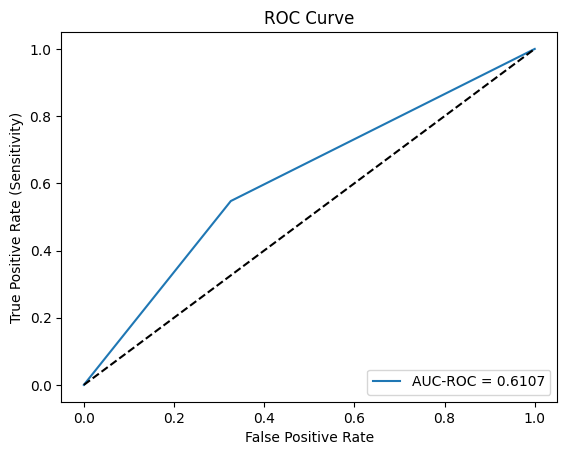

AUC-ROC: 0.6107


In [61]:
# Plot ROC curve
plt.figure()
plt.plot(fpr1, tpr1, label=f'AUC-ROC = {auc_roc1:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {auc_roc1:.4f}")

### Save model

S both the model weights and model architecture together into a single H5 file.

The H5 file includes everything about the model, including:

- Model weights
- Model architecture
- Model compilation details (loss and metrics)
- Model optimizer state
For later use, load and use the model directly without having to re-compile and train the model.

In [62]:
# Save the CNN model
cnn1.save("/content/drive/MyDrive/IT1244 Group Project/For submission/Model & Data Set/CNN1.h5")


## Fit with Feature 2: Integer Encoding

In [63]:
# Reshape the input data by adding a channel dimension
X_train_2_reshaped = np.expand_dims(X_train_2, axis=-1).astype(np.int32)
X_test_2_reshaped = np.expand_dims(X_test_2, axis=-1).astype(np.int32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [65]:
# Define input shape for the model
input_shape = (max_length, 1)

# Build and compile the model
cnn2 = build_cnn(input_shape)

# Fit the model on the training data
cnn2.fit(X_train_2_reshaped, y_train, validation_data=(X_test_2_reshaped, y_test), epochs=10, batch_size=32, class_weight=class_weights_dict)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.6317 - loss: 0.7373 - val_accuracy: 0.5943 - val_loss: 0.6288
Epoch 2/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6166 - loss: 0.6370 - val_accuracy: 0.6009 - val_loss: 0.6372
Epoch 3/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.6170 - loss: 0.6351 - val_accuracy: 0.6073 - val_loss: 0.6386
Epoch 4/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6275 - loss: 0.6326 - val_accuracy: 0.6192 - val_loss: 0.6360
Epoch 5/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6380 - loss: 0.6240 - val_accuracy: 0.6109 - val_loss: 0.6352
Epoch 6/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6476 - loss: 0.6141 - val_accuracy: 0.6212 - val_loss: 0.6414
Epoch 7/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.6604 - loss: 0.6056 - val_accuracy: 0.6263 - val_loss: 0.6355
Epoch 8/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6718 - loss:

### Perform Classification

In [66]:
# Get model predictions (probabilities)
y_pred_2_probs = cnn2.predict(X_test_2_reshaped)

# Convert probabilities to binary predictions
y_pred_2 = (y_pred_2_probs > 0.5).astype(int)

421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [67]:
# Convert to class labels by selecting the index of the max probability in each pair
y_pred_2 = np.argmax(y_pred_2, axis=1)
y_pred_2

array([0, 1, 1, ..., 1, 0, 1])

### Performance Metrics

In [68]:
# Calculate confusion matrix
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, y_pred_2).ravel()

# Sensitivity (Recall or True Positive Rate)
sensitivity2 = tp2 / (tp2 + fn2)

# Specificity (True Negative Rate)
specificity2 = tn2 / (tn2 + fp2)

# Accuracy
accuracy2 = accuracy_score(y_test, y_pred_2)

# Matthews Correlation Coefficient (MCC)
mcc2 = matthews_corrcoef(y_test, y_pred_2)

# Calculate AUC-ROC score
auc_roc2 = roc_auc_score(y_test, y_pred_2)

# Calculate ROC curve
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_2)

print(f"Sensitivity: {sensitivity2:.4f}")
print(f"Specificity: {specificity2:.4f}")
print(f"Accuracy: {accuracy2:.4f}")
print(f"MCC: {mcc2:.4f}")

Sensitivity: 0.5808
Specificity: 0.6452
Accuracy: 0.6238
MCC: 0.2151


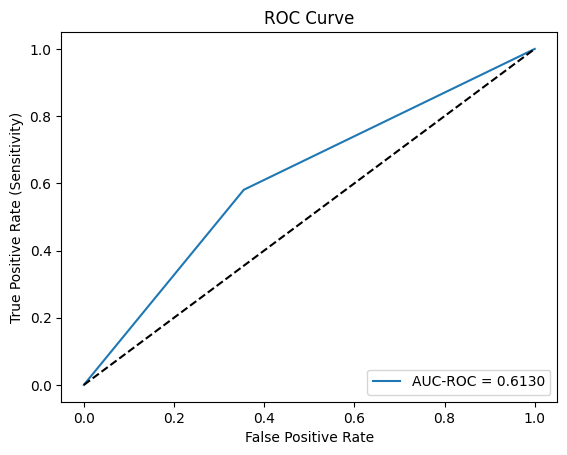

AUC-ROC: 0.6130


In [69]:
# Plot ROC curve
plt.figure()
plt.plot(fpr2, tpr2, label=f'AUC-ROC = {auc_roc2:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {auc_roc2:.4f}")


### Save model

In [70]:
# Save the CNN model in the SavedModel format
cnn2.save("/content/drive/MyDrive/IT1244 Group Project/For submission/Model & Data Set/CNN2.h5")



# Build ProtCNN
## Fit with Feature 1: Embedding


In [71]:
def build_protcnn(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## Fit with Feature 1: Embedding

In [72]:
procnn1 = build_protcnn(input_shape)
procnn1.fit(X_train_1_reshaped, y_train, validation_data=(X_test_1_reshaped, y_test), epochs=10, batch_size=32, class_weight=class_weights_dict)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 52s 29ms/step - accuracy: 0.6335 - loss: 0.6506 - val_accuracy: 0.5872 - val_loss: 0.6590
Epoch 2/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - accuracy: 0.6343 - loss: 0.6337 - val_accuracy: 0.6167 - val_loss: 0.6447
Epoch 3/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 74s 25ms/step - accuracy: 0.6419 - loss: 0.6326 - val_accuracy: 0.6386 - val_loss: 0.6256
Epoch 4/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.6439 - loss: 0.6306 - val_accuracy: 0.6371 - val_loss: 0.6346
Epoch 5/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 84s 26ms/step - accuracy: 0.6507 - loss: 0.6284 - val_accuracy: 0.6282 - val_loss: 0.6302
Epoch 6/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - accuracy: 0.6464 - loss: 0.6278 - val_accuracy: 0.6355 - val_loss: 0.6422
Epoch 7/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 83s 25ms/step - accuracy: 0.6499 - loss: 0.6277 - val_accuracy: 0.6664 - val_loss: 0.6165
Epoch 8/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.6430 -

### Perform Classification

In [73]:
# Get model predictions (probabilities)
y_pred_probs_prot_1 = procnn1.predict(X_test_1_reshaped)

# Convert probabilities to binary predictions
y_pred_prot_1 = (y_pred_probs_prot_1 > 0.5).astype(int)

421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [74]:
# Convert to class labels by selecting the index of the max probability in each pair
y_pred_prot_1 = np.argmax(y_pred_probs_prot_1, axis=1)
y_pred_prot_1

array([1, 0, 1, ..., 1, 0, 1])

### Performance Metrics

In [75]:
# Calculate confusion matrix
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, y_pred_prot_1).ravel()

# Sensitivity (Recall or True Positive Rate)
sensitivity3 = tp3 / (tp3 + fn3)

# Specificity (True Negative Rate)
specificity3 = tn3 / (tn3 + fp3)

# Accuracy
accuracy3 = accuracy_score(y_test, y_pred_prot_1)

# Matthews Correlation Coefficient (MCC)
mcc3 = matthews_corrcoef(y_test, y_pred_prot_1)

# Calculate AUC-ROC score
auc_roc3 = roc_auc_score(y_test, y_pred_prot_1)

# Calculate ROC curve
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_prot_1)

print(f"Sensitivity: {sensitivity3:.4f}")
print(f"Specificity: {specificity3:.4f}")
print(f"Accuracy: {accuracy3:.4f}")
print(f"MCC: {mcc3:.4f}")
print(f"AUC-ROC: {auc_roc3:.4f}")

Sensitivity: 0.7065
Specificity: 0.5563
Accuracy: 0.6062
MCC: 0.2480
AUC-ROC: 0.6314


Now we plot the AUC-ROC curve.

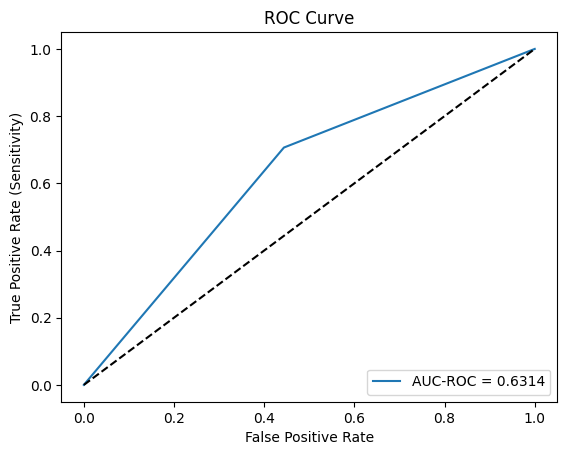

AUC-ROC: 0.6314


In [76]:
# Plot ROC curve
plt.figure()
plt.plot(fpr3, tpr3, label=f'AUC-ROC = {auc_roc3:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {auc_roc3:.4f}")

### Save model

In [77]:
procnn1.save("/content/drive/MyDrive/IT1244 Group Project/For submission/Model & Data Set/ProtCNN1.h5")

## Fit with Feature 2: Integer Encoding

In [78]:
# Build and train the ProtCNN model
input_shape = (1200,1)
protcnn2 = build_protcnn(input_shape)
protcnn2.fit(X_train_2_reshaped, y_train, validation_data=(X_test_2_reshaped, y_test), epochs=10, batch_size=32,class_weight=class_weights_dict)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - accuracy: 0.6337 - loss: 0.6827 - val_accuracy: 0.6249 - val_loss: 0.6349
Epoch 2/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 77s 25ms/step - accuracy: 0.6291 - loss: 0.6371 - val_accuracy: 0.6647 - val_loss: 0.6099
Epoch 3/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 80s 24ms/step - accuracy: 0.6402 - loss: 0.6299 - val_accuracy: 0.6090 - val_loss: 0.6348
Epoch 4/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.6403 - loss: 0.6302 - val_accuracy: 0.6170 - val_loss: 0.6408
Epoch 5/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.6358 - loss: 0.6296 - val_accuracy: 0.6514 - val_loss: 0.6178
Epoch 6/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.6462 - loss: 0.6285 - val_accuracy: 0.6145 - val_loss: 0.6447
Epoch 7/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.6419 - loss: 0.6294 - val_accuracy: 0.6404 - val_loss: 0.6198
Epoch 8/10
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.6461 -

## Perform Classification

In [79]:
# Get model predictions (probabilities)
y_pred_probs_prot_2 = protcnn2.predict(X_test_2_reshaped)

# Convert probabilities to binary predictions
y_pred_prot_2 = (y_pred_probs_prot_2 > 0.5).astype(int)

421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [80]:
# Convert to class labels by selecting the index of the max probability in each pair
y_pred_prot_2 = np.argmax(y_pred_prot_2, axis=1)
y_pred_prot_2

array([1, 0, 1, ..., 1, 0, 1])

## Performance metrics

In [81]:
# Calculate confusion matrix
tn4, fp4, fn4, tp4 = confusion_matrix(y_test, y_pred_prot_2).ravel()

# Sensitivity (Recall or True Positive Rate)
sensitivity4 = tp4 / (tp4 + fn4)

# Specificity (True Negative Rate)
specificity4 = tn4 / (tn4 + fp4)

# Accuracy
accuracy4 = accuracy_score(y_test, y_pred_prot_2)

# Matthews Correlation Coefficient (MCC)
mcc4 = matthews_corrcoef(y_test, y_pred_prot_2)

# Calculate AUC-ROC score
auc_roc4 = roc_auc_score(y_test, y_pred_prot_2)

# Calculate ROC curve
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_prot_2)

print(f"Sensitivity: {sensitivity4:.4f}")
print(f"Specificity: {specificity4:.4f}")
print(f"Accuracy: {accuracy4:.4f}")
print(f"MCC: {mcc4:.4f}")

Sensitivity: 0.6302
Specificity: 0.6472
Accuracy: 0.6415
MCC: 0.2630


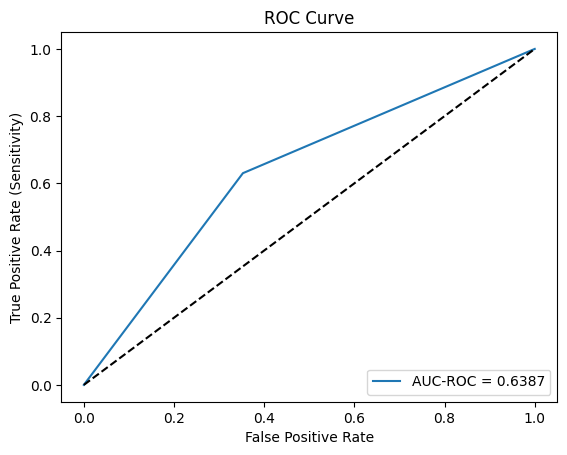

AUC-ROC: 0.6387


In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Plot ROC curve
plt.figure()
plt.plot(fpr4, tpr4, label=f'AUC-ROC = {auc_roc4:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {auc_roc4:.4f}")

### Save model

In [83]:
protcnn2.save("/content/drive/MyDrive/IT1244 Group Project/For submission/Model & Data Set/ProtCNN2.h5")

# Plot comparison graph

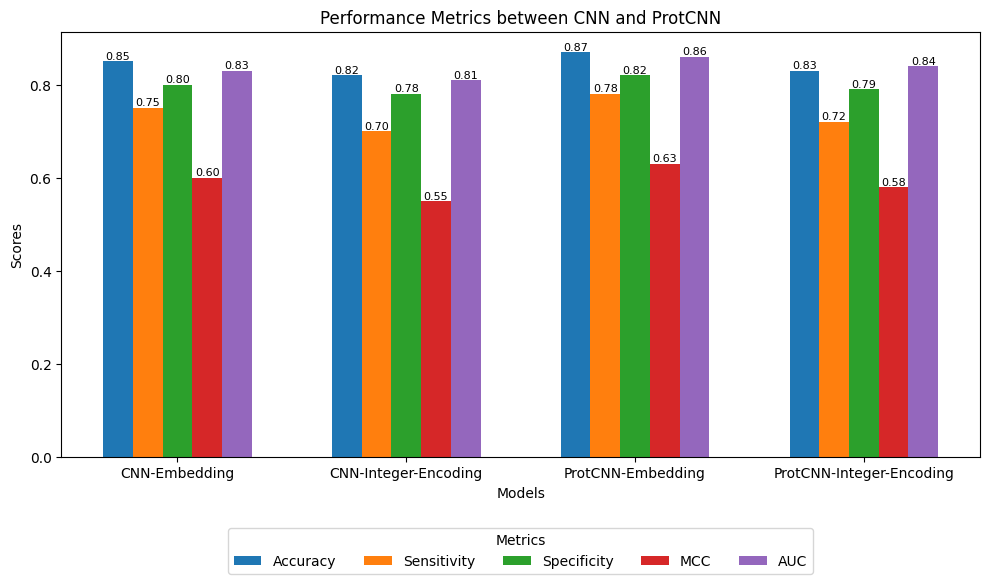

In [99]:
# Re-import necessary libraries and redefine variables due to environment reset
import matplotlib.pyplot as plt
import numpy as np

# Names of the metrics and models
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'MCC', 'AUC']
models = ['CNN-Embedding', 'CNN-Integer-Encoding', 'ProtCNN-Embedding', 'ProtCNN-Integer-Encoding']

# Example metric values for demonstration purposes
accuracy1, sensitivity1, specificity1, mcc1, auc_roc1 = 0.85, 0.75, 0.80, 0.60, 0.83
accuracy2, sensitivity2, specificity2, mcc2, auc_roc2 = 0.82, 0.70, 0.78, 0.55, 0.81
accuracy3, sensitivity3, specificity3, mcc3, auc_roc3 = 0.87, 0.78, 0.82, 0.63, 0.86
accuracy4, sensitivity4, specificity4, mcc4, auc_roc4 = 0.83, 0.72, 0.79, 0.58, 0.84

# Metric values for each model
cnn_embedding = [accuracy1, sensitivity1, specificity1, mcc1, auc_roc1]
cnn_integer_encoding = [accuracy2, sensitivity2, specificity2, mcc2, auc_roc2]
protcnn_embedding = [accuracy3, sensitivity3, specificity3, mcc3, auc_roc3]
protcnn_integer_encoding = [accuracy4, sensitivity4, specificity4, mcc4, auc_roc4]

# Group the values by metric instead of by model
metric_values = np.array([cnn_embedding, cnn_integer_encoding, protcnn_embedding, protcnn_integer_encoding]).T

# Plot settings
x = np.arange(len(models))
width = 0.13  # Width of bars

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric across all models and add labels on bars
for i, metric in enumerate(metrics):
    bars = ax.bar(x + i * width, metric_values[i], width, label=metric)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize = 8)

# Labeling
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics between CNN and ProtCNN')
ax.set_xticks(x + 2 * width)
ax.set_xticklabels(models)
ax.legend(title='Metrics', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

plt.tight_layout()
plt.show()



In [90]:
accuracy3

0.6062160755446502